In [58]:
#线性回归（非框架）
%matplotlib inline
#在使用%matplotlib inline命令后，你可以不使用plt.show()就能在notebook或IPython的终端内进行绘图，并将输出的图形嵌入到notebook,需要先在这个环境中安装matplotlib包
import random
import torch
from d2l import torch as d2l

In [59]:
#根据带有噪声的线性模型构造一个人造数据集，我们使用线性模型参数w=[2,-3.4]^T、b = 4.2和噪声项€生成数据集及其标签
def synthetic_data(w,b,num_examples):
    """生成y=Xw + b + 噪声"""
    #torch.normal(0,1(num_examples,len(w)))指生成一个维度为num_examples × len(w)的随机张量X，其中每个元素都是从均值为0、标准差为1的正态分布中随机采样得到的，因此对于神经网络的输入数据的维度等于，输入样本的个数*权重的个数
    X = torch.normal(0,1,(num_examples,len(w)))
    #torch.matmul(X,w)是指对矩阵X和w执行矩阵乘法
    y = torch.matmul(X,w)+b
    #加上一个与y同形状的噪声矩阵
    y += torch.normal(0,0.01,y.shape)
    #将y转换成列向量返回
    return X,y.reshape((-1,1))
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [60]:
print('features:',features[0],'labels:',labels[0])

features: tensor([ 0.9443, -0.6212]) labels: tensor([8.1961])


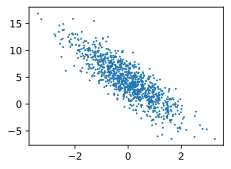

In [61]:
#将样本数据画在坐标上
d2l.set_figsize()#设置Matplotlib图的尺寸,使画的图展示出来
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)
#在d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)中，features[:, 1].detach().numpy()表示取出数据在第2列上的值作为横坐标，labels.detach().numpy()表示取出标签数据作为纵坐标，1表示点的大小为1。由于features和labels通常是由PyTorch张量表示的，因此需要使用.detach().numpy()将其转换为NumPy数组类型，以便使用Matplotlib来进行可视化

In [77]:
#定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量进行数据处理
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    # print("nun_example:",num_example,'\n')
    indices = list(range(num_examples))
    #将样本下标随机打乱
    random.shuffle(indices)
    # print("indices:",indices,'\n')
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
        indices[i:min(i+batch_size,num_examples)]
    )
    # print("batch_indices:",batch_indices,'\n')
    #tensor变量可以以另一个tensor作为下标，表示取出该tensor下标对应的元素作为一个新的tensor
        yield features[batch_indices],labels[batch_indices]
    #使用 Python 中的 yield 关键字产生一个生成器，在下一次迭代时继续执行上次迭代中的代码，返回由当前批次样本组成的二元组，每个元组元素分别为训练样本和对应的标签。yield使函数返回的值可以逐个地迭代，直到函数执行完或遇到 StopIteration 错误。该函数返回的是一个生成器，用该生成器来循环访问整个训练集
batch_size = 10
#data_iter中使用了yield，因此是一个生成器函数。可以使用for循环来接收该函数生成的数据，这样可以避免产生异常
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-0.7981,  1.4604],
        [ 0.6581,  1.0559],
        [-1.2647, -0.1020],
        [ 1.0121,  1.7790],
        [-0.1634,  0.3928],
        [ 1.9760,  1.5531],
        [ 1.6966,  0.5681],
        [ 1.2154, -0.7876],
        [-0.5149,  0.3674],
        [-0.1385,  0.1583]]) 
 tensor([[-2.3630],
        [ 1.9165],
        [ 2.0069],
        [ 0.1749],
        [ 2.5170],
        [ 2.8564],
        [ 5.6579],
        [ 9.3192],
        [ 1.9439],
        [ 3.3822]])


In [69]:
#定义初始化参数
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)#第一个参数表示形状
w,b

(tensor([[ 0.0146],
         [-0.0073]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [70]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b #matmul()函数是pytorch的矩阵乘法

In [71]:
def squared_loss(predict_y,y):
    """"均方误差"""
    return (predict_y-y.reshape(predict_y.shape))**2/2

In [72]:
#定义优化算法,步长和随机样本
def sgd(params,lr,batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size#此处除以batch_size的原因是因为在求均方误差的时候没有去均值，因为在哪里取均值对梯度没有影响，所以这次在这里去均值
            param.grad.zero_()

In [78]:
#训练过程
lr = 0.03
num_epochs = 3
#下面两行表示将函数另外去名字
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    i=0
    for X,y in data_iter(batch_size,features,labels):
        print('i:',i)
        i+=1
        l = loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch + 1},loss {float(train_l.mean()):f}')

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
i: 80
i: 81
i: 82
i: 83
i: 84
i: 85
i: 86
i: 87
i: 88
i: 89
i: 90
i: 91
i: 92
i: 93
i: 94
i: 95
i: 96
i: 97
i: 98
i: 99
epoch1,loss 0.000053
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 